## Setup & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import torch
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import random
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List

from google.colab import drive
# drive.mount('/content/drive/Shareddrives')
%cd /content/drive/MyDrive/DL Final Project
base_data_path = "/content/drive/MyDrive/DL Final Project/STARE_cleaned/"

/content/drive/.shortcut-targets-by-id/1uPpg4Yr8uev2brz5QIGI5ObT-zin6hvX/DL Final Project


## Building the Dataset - Augmentation Pipeline

In [3]:
def apply_dropout(img: torch.Tensor, mask: torch.Tensor, p: float = 0.1) -> Tuple[torch.Tensor, torch.Tensor]:
    img_out = F.dropout(img, p=p, training=True)
    mask = mask.mean(dim=0, keepdim=True)
    return img_out, mask

def add_white_noise(img: torch.Tensor, mask: torch.Tensor, mean: float = 0.0, std: float = 0.05) -> Tuple[torch.Tensor, torch.Tensor]:
    noise = torch.randn_like(img) * std + mean
    noisy = torch.clamp(img + noise, 0.0, 1.0)
    mask = mask.mean(dim=0, keepdim=True)
    return noisy, mask

def gamma_correction(img: torch.Tensor, mask: torch.Tensor, gamma: float = 1.5) -> Tuple[torch.Tensor, torch.Tensor]:
    corrected = torch.clamp(img ** gamma, 0.0, 1.0)
    mask = mask.mean(dim=0, keepdim=True)
    return corrected, mask

def histogram_equalization(img: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    np_img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    lab = cv2.cvtColor(np_img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    eq = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    eq = torch.tensor(eq / 255.0, dtype=torch.float32).permute(2, 0, 1)
    mask = mask.mean(dim=0, keepdim=True)
    return eq, mask

def apply_blur(img: torch.Tensor, mask: torch.Tensor, kernel_size: int = 5) -> Tuple[torch.Tensor, torch.Tensor]:
    np_img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(np_img, (kernel_size, kernel_size), 0)
    blurred_t = torch.tensor(blurred / 255.0, dtype=torch.float32).permute(2, 0, 1)
    mask = mask.mean(dim=0, keepdim=True)
    return blurred_t, mask

def elastic_deformation(img: torch.Tensor, mask: torch.Tensor, alpha: float = 34, sigma: float = 4):
    np_img = img.permute(1, 2, 0).numpy()
    np_mask = mask.permute(1, 2, 0).numpy()
    random_state = np.random.RandomState(None)
    shape = np_img.shape[:2]

    dx = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (17, 17), sigma) * alpha
    dy = cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1), (17, 17), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)

    img_def = np.zeros_like(np_img)
    for c in range(np_img.shape[2]):
        img_def[..., c] = cv2.remap(
            np_img[..., c], map_x, map_y,
            interpolation=cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_REFLECT
        )

    mask_def = np.zeros_like(np_mask)
    for c in range(np_mask.shape[2]):
        mask_def[..., c] = cv2.remap(
            np_mask[..., c], map_x, map_y,
            interpolation=cv2.INTER_NEAREST,
            borderMode=cv2.BORDER_REFLECT
        )

    img_out = torch.tensor(img_def, dtype=torch.float32).permute(2, 0, 1)
    mask_out = torch.tensor(mask_def, dtype=torch.float32).permute(2, 0, 1)

    mask_out = mask_out.mean(dim=0, keepdim=True)

    return img_out, mask_out

def random_flip(img: torch.Tensor, mask: torch.Tensor):
    if random.random() > 0.5:
        img = TF.hflip(img)
        mask = TF.hflip(mask)
    if random.random() > 0.5:
        img = TF.vflip(img)
        mask = TF.vflip(mask)
    mask = mask.mean(dim=0, keepdim=True)
    return img, mask

def apply_shear(img: torch.Tensor, mask: torch.Tensor, degrees: float = 10):
    shear = random.uniform(-degrees, degrees)
    img_out = TF.affine(img, angle=0, translate=[0, 0], scale=1.0, shear=[shear])
    mask_out = TF.affine(mask, angle=0, translate=[0, 0], scale=1.0, shear=[shear])
    mask_out = mask_out.mean(dim=0, keepdim=True)
    return img_out, mask_out

def apply_sharpening(img: torch.Tensor, mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    np_img = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharp = cv2.filter2D(np_img, -1, kernel)
    sharp_t = torch.tensor(sharp / 255.0, dtype=torch.float32).permute(2, 0, 1)
    mask = mask.mean(dim=0, keepdim=True)
    return sharp_t, mask

def boost_saturation(img: torch.Tensor, mask: torch.Tensor, factor: float = 1.5) -> Tuple[torch.Tensor, torch.Tensor]:
    pil_img = TF.to_pil_image(img)
    enhancer = transforms.ColorJitter(saturation=factor)
    img_out = enhancer(pil_img)
    mask = mask.mean(dim=0, keepdim=True)
    return TF.to_tensor(img_out), mask

In [4]:
def augment_image(image_tensor, mask_tensor) -> List[Tuple]:
  variations = []
  # variations.append(apply_dropout(image_tensor, mask_tensor))
  # variations.append(add_white_noise(image_tensor, mask_tensor, std=0.01))
  # variations.append(gamma_correction(image_tensor, mask_tensor, gamma=1.2)) # problem here
  # variations.append(histogram_equalization(image_tensor, mask_tensor))
  # variations.append(apply_blur(image_tensor, mask_tensor))
  # variations.append(elastic_deformation(image_tensor, mask_tensor, alpha=10, sigma=6))
  variations.append(random_flip(image_tensor, mask_tensor))
  # variations.append(apply_shear(image_tensor, mask_tensor))
  # variations.append(apply_sharpening(image_tensor, mask_tensor))
  # variations.append(boost_saturation(image_tensor, mask_tensor))

  return variations

In [5]:
class AugmentedImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, augment_fn=None, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.augment_fn = augment_fn
        self.samples = []

        print(f"Processing dataset from {annotations_file}...")

        for idx in range(len(self.img_labels)):
            img_name = str(self.img_labels.iloc[idx, 0])
            label_vector = self.img_labels.iloc[idx, 1:].values.astype('float32')
            label = torch.tensor(label_vector)
            img_path = os.path.join(self.img_dir, img_name)
            if not os.path.exists(img_path):
                if os.path.exists(img_path + '.png'):
                    img_path += '.png'
                else:
                    continue

            image = Image.open(img_path).convert("RGB")
            if self.transform:
                img_tensor = self.transform(image)
            else:
                img_tensor = TF.to_tensor(image)
            self.samples.append((img_tensor, label))
            if self.augment_fn:
                dummy_mask = torch.zeros((1, img_tensor.shape[1], img_tensor.shape[2]))
                variations = self.augment_fn(img_tensor, dummy_mask)
                for aug_img, _ in variations:
                    self.samples.append((aug_img, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

## RetinaLiteNet

In [6]:
class ChannelAttention(nn.Module):
    def __init__(self, channels: int, reduction: int):
        super().__init__()
        reduction = max(1, reduction)
        hidden = max(1, channels // reduction)
        self.mlp = nn.Sequential(
            nn.Linear(channels, hidden, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, channels, bias=False),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, _, _ = x.shape
        avg = F.adaptive_avg_pool2d(x, 1).view(b, c)
        max_ = F.adaptive_max_pool2d(x, 1).view(b, c)
        attn = self.mlp(avg) + self.mlp(max_)
        scale = torch.sigmoid(attn).view(b, c, 1, 1)
        return x * scale

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size: int):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.cat([avg, max_], dim=1)
        scale = torch.sigmoid(self.conv(attn))
        return x * scale

class CBAM(nn.Module):
    def __init__(self, channels: int, reduction: int = 1, spatial_kernel: int = 7):
        super().__init__()
        self.channel_attn = ChannelAttention(channels, reduction)
        self.spatial_attn = SpatialAttention(spatial_kernel)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.channel_attn(x)
        x = self.spatial_attn(x)
        return x

In [7]:
class RetinaLiteEncoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.enc3 = nn.Sequential(
            nn.Conv2d(24, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, list[torch.Tensor]]:
        skip1 = self.enc1(x)
        x = self.pool1(skip1)

        skip2 = self.enc2(x)
        x = self.pool2(skip2)

        bottleneck = self.enc3(x)
        skips = [skip1, skip2]
        return bottleneck, skips


class MHABottleneck(nn.Module):

    def __init__(self, channels: int = 64, num_heads: int = 4, dropout: float = 0.0):
        super().__init__()
        self.channels = channels
        self.attn = nn.MultiheadAttention(
            embed_dim=channels,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True,
        )
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * 2, channels, kernel_size=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, c, h, w = x.shape
        tokens = x.permute(0, 2, 3, 1).reshape(b, h * w, c)
        attn_out, _ = self.attn(tokens, tokens, tokens)
        attn_map = attn_out.reshape(b, h, w, c).permute(0, 3, 1, 2)
        fused = torch.cat([x, attn_map], dim=1)
        out = self.fuse(fused)
        return out


class RetinaLiteDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.up1 = nn.ConvTranspose2d(64, 24, kernel_size=2, stride=2)
        self.skip_attn2 = CBAM(24)
        self.fuse1 = nn.Sequential(
            nn.Conv2d(24 + 24, 24, kernel_size=3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose2d(24, 12, kernel_size=2, stride=2)
        self.skip_attn1 = CBAM(12)
        self.fuse2 = nn.Sequential(
            nn.Conv2d(12 + 12, 12, kernel_size=3, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor, skips: list[torch.Tensor]) -> torch.Tensor:
        skip1, skip2 = skips
        skip2 = self.skip_attn2(skip2)

        x = self.up1(x)
        x = torch.cat([x, skip2], dim=1)
        x = self.fuse1(x)

        skip1 = self.skip_attn1(skip1)
        x = self.up2(x)
        x = torch.cat([x, skip1], dim=1)
        x = self.fuse2(x)
        return x


class RetinaLiteNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = RetinaLiteEncoder()
        self.bottleneck = MHABottleneck()
        self.decoder = RetinaLiteDecoder()
        self.bv_head = nn.Conv2d(12, 1, kernel_size=1)
        # self.od_head = nn.Conv2d(12, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        bottleneck, skips = self.encoder(x)
        fused = self.bottleneck(bottleneck)
        features = self.decoder(fused, skips)
        bv = self.bv_head(features)
        # od = self.od_head(features)
        # return bv, od
        return bv

In [8]:
model = RetinaLiteNet()
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

Total parameters: 64113


In [9]:
decoder = RetinaLiteDecoder()
decoder_params = sum(p.numel() for p in decoder.parameters())
print("Decoder parameters:", decoder_params)

Decoder parameters: 22036


## Create DataLoaders

In [10]:
train_csv = base_data_path + 'train_labels.csv'
train_img_dir = base_data_path + 'train_images'


test_csv = base_data_path + 'test_labels.csv'
test_img_dir = base_data_path + 'test_images'

resize_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = AugmentedImageDataset(
    annotations_file=train_csv,
    img_dir=train_img_dir,
    augment_fn=augment_image,
    transform=resize_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = AugmentedImageDataset(
    annotations_file=test_csv,
    img_dir=test_img_dir,
    augment_fn=None,
    transform=resize_transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Processing dataset from /content/drive/MyDrive/DL Final Project/STARE_cleaned/train_labels.csv...
Processing dataset from /content/drive/MyDrive/DL Final Project/STARE_cleaned/test_labels.csv...
Train dataset size: 428
Test dataset size: 93


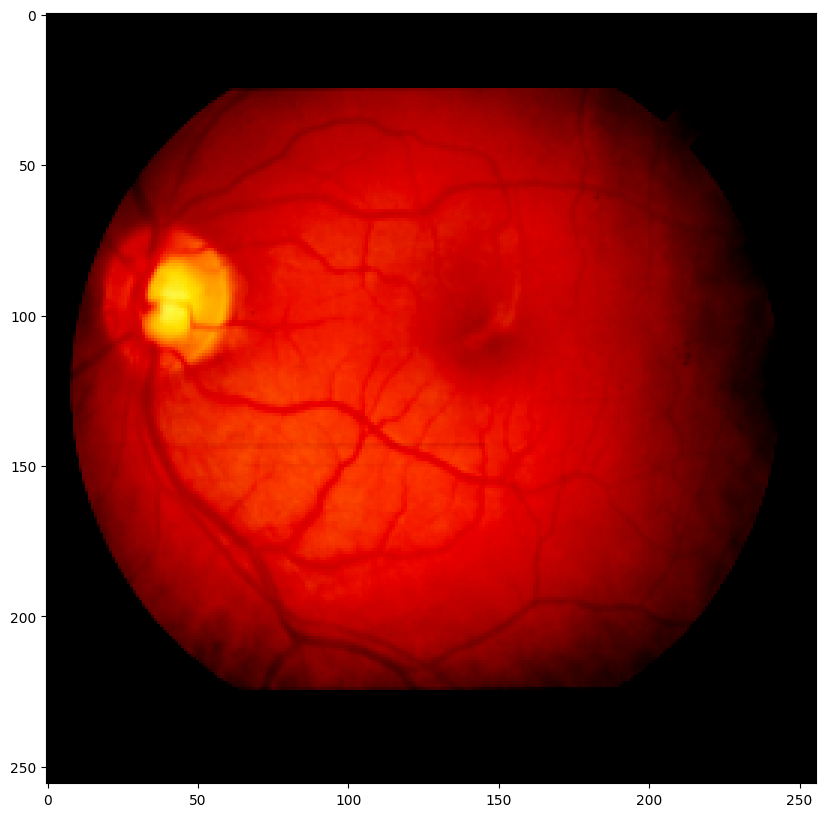

In [11]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(images[0].permute(1, 2, 0))
plt.show()

In [12]:
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

def final_eval(model, dataloader, device="cuda", threshold=0.5):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs >= threshold).int()
            all_probs.append(probs.cpu().numpy())
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y.numpy())
    all_probs  = np.vstack(all_probs)
    all_preds  = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    seq_acc = np.mean(np.all(all_preds == all_labels, axis=1))
    micro_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    macro_auc = roc_auc_score(all_labels, all_probs, average="macro")

    print(f"  Sequence Accuracy: {seq_acc:.4f}")
    print(f"  Micro F1:          {micro_f1:.4f}")
    print(f"  Macro F1:          {macro_f1:.4f}")
    print(f"  Macro AUC:         {macro_auc:.4f}")

    return seq_acc, micro_f1, macro_f1, macro_auc

## Define RetinaLiteClassifier Architecture

In [13]:
class ClassifierHead(nn.Module):
    def __init__(self, num_classes=14):
        super().__init__()

        self.skip2_attn = CBAM(24)
        self.skip2_down = nn.Sequential(
            nn.Conv2d(24, 24, kernel_size=3, stride=2, padding=1,),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True)
        )

        self.skip1_attn = CBAM(12)
        self.skip1_down = nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=3, stride=2, padding=1,),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
            nn.Conv2d(12, 12, kernel_size=3, stride=2, padding=1,),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True)
        )

        self.fuse = nn.Sequential(
            nn.Conv2d(100, 16, kernel_size=1,),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )

        self.spatial_reduce = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=4, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x: torch.Tensor, skips: list[torch.Tensor]) -> torch.Tensor:
        skip1, skip2 = skips
        s1 = self.skip1_down(self.skip1_attn(skip1))
        s2 = self.skip2_down(self.skip2_attn(skip2))
        fused = torch.cat([x, s2, s1], dim=1)
        x = self.fuse(fused)
        x = self.spatial_reduce(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class RetinaLiteClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = RetinaLiteEncoder()
        self.bottleneck = MHABottleneck()
        self.head = ClassifierHead()

    def forward(self, x):
        bottleneck_features, skips = self.encoder(x)
        fused = self.bottleneck(bottleneck_features)
        out = self.head(fused, skips)
        return out

In [61]:
classifier_model = RetinaLiteClassifier()

head_params = sum(p.numel() for p in classifier_model.head.parameters())
print(f"Classifier Head parameters: {head_params}")

Classifier Head parameters: 24594


### Load Weights For Encoder

In [51]:
model_path = "/content/drive/MyDrive/DL Final Project/model_final.pth"
if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location="cpu")

    encoder_dict = {
        k.replace("encoder.", ""): v
        for k, v in checkpoint.items()
        if k.startswith("encoder.")
    }

    missing, unexpected = classifier_model.encoder.load_state_dict(encoder_dict, strict=False)
    for param in classifier_model.encoder.parameters():
        param.requires_grad = False

else:
    print("Didnt work")


## Train Classifier

In [52]:
from sklearn.metrics import f1_score, roc_auc_score

def compute_f1(model, data_loader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.cpu().numpy()

            logits = model(images)
            probs = torch.sigmoid(logits).cpu().numpy()

            preds = (probs > threshold).astype(int)

            all_labels.append(labels)
            all_preds.append(preds)

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    micro_f1 = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    macro_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    return micro_f1, macro_f1


def compute_f1_2(outputs, labels, threshold=0.2):
    probs = torch.sigmoid(outputs)
    preds = (probs > threshold).int()
    labels = labels.int()

    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    micro = f1_score(labels, preds, average="micro", zero_division=0)
    macro = f1_score(labels, preds, average="macro", zero_division=0)
    return micro, macro


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classifier_model = classifier_model.to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, classifier_model.parameters()), lr=0.001)

num_epochs = 30
train_losses = []
test_losses = []


print(f"Starting Multi-Label training on {device}...")

for epoch in range(num_epochs):
    classifier_model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        images = images.to(device)

        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = classifier_model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    classifier_model.eval()
    running_test_loss = 0.0
    all_outputs_epoch = []
    all_labels_epoch = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]", leave=False):
            images = images.to(device)

            labels = labels.float().to(device)

            outputs = classifier_model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()
            all_outputs_epoch.append(outputs.cpu())
            all_labels_epoch.append(labels.cpu())

    all_outputs_epoch = torch.cat(all_outputs_epoch)
    all_labels_epoch = torch.cat(all_labels_epoch)

    micro, macro = compute_f1_2(all_outputs_epoch, all_labels_epoch)
    probs = torch.sigmoid(all_outputs_epoch).numpy()
    labels_np = all_labels_epoch.numpy()
    preds = (probs >= 0.5).astype(int)
    subset_acc = (preds == labels_np).all(axis=1).mean()
    macro_f1 = f1_score( labels_np, preds, average='macro')
    macro_auc = roc_auc_score(labels_np, probs, average='macro')
    print(f"\tSubset Acc: {subset_acc:.4f} | Macro F1: {macro_f1:.4f} | Macro AUC: {macro_auc:.4f}")

    epoch_test_loss = running_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | F1: {micro:.4f} & {macro:.4f}")

Starting Multi-Label training on cuda...


	Subset Acc: 0.0215 | Macro F1: 0.0084 | Macro AUC: 0.4839
Epoch [1/30] | Train Loss: 0.5521 | Test Loss: 0.5849 | F1: 0.1545 & 0.1497


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.5537
Epoch [2/30] | Train Loss: 0.3780 | Test Loss: 0.3545 | F1: 0.1931 & 0.1313


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.5894
Epoch [3/30] | Train Loss: 0.3164 | Test Loss: 0.2854 | F1: 0.2172 & 0.0556


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.6596
Epoch [4/30] | Train Loss: 0.2977 | Test Loss: 0.2724 | F1: 0.2353 & 0.0465


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.6282
Epoch [5/30] | Train Loss: 0.2869 | Test Loss: 0.2705 | F1: 0.2437 & 0.0496


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.6102
Epoch [6/30] | Train Loss: 0.2806 | Test Loss: 0.2715 | F1: 0.2368 & 0.0602


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.6216
Epoch [7/30] | Train Loss: 0.2754 | Test Loss: 0.2675 | F1: 0.2767 & 0.0756


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.6524
Epoch [8/30] | Train Loss: 0.2691 | Test Loss: 0.2708 | F1: 0.2353 & 0.0480


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.6699
Epoch [9/30] | Train Loss: 0.2636 | Test Loss: 0.2667 | F1: 0.2588 & 0.0803


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.6820
Epoch [10/30] | Train Loss: 0.2568 | Test Loss: 0.2597 | F1: 0.2944 & 0.0965


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.6957
Epoch [11/30] | Train Loss: 0.2583 | Test Loss: 0.2717 | F1: 0.2243 & 0.0586


	Subset Acc: 0.0000 | Macro F1: 0.0000 | Macro AUC: 0.6740
Epoch [12/30] | Train Loss: 0.2551 | Test Loss: 0.2605 | F1: 0.3319 & 0.1963


	Subset Acc: 0.0215 | Macro F1: 0.0152 | Macro AUC: 0.6766
Epoch [13/30] | Train Loss: 0.2441 | Test Loss: 0.2605 | F1: 0.2800 & 0.1336


	Subset Acc: 0.0108 | Macro F1: 0.0238 | Macro AUC: 0.6949
Epoch [14/30] | Train Loss: 0.2482 | Test Loss: 0.2661 | F1: 0.2870 & 0.1497


	Subset Acc: 0.0968 | Macro F1: 0.0846 | Macro AUC: 0.6875
Epoch [15/30] | Train Loss: 0.2432 | Test Loss: 0.2591 | F1: 0.2952 & 0.1499


	Subset Acc: 0.0968 | Macro F1: 0.0824 | Macro AUC: 0.7359
Epoch [16/30] | Train Loss: 0.2366 | Test Loss: 0.2521 | F1: 0.3033 & 0.1998


	Subset Acc: 0.0860 | Macro F1: 0.0762 | Macro AUC: 0.7195
Epoch [17/30] | Train Loss: 0.2352 | Test Loss: 0.2651 | F1: 0.2651 & 0.1506


	Subset Acc: 0.0323 | Macro F1: 0.0389 | Macro AUC: 0.6738
Epoch [18/30] | Train Loss: 0.2254 | Test Loss: 0.2676 | F1: 0.2581 & 0.1228


	Subset Acc: 0.0753 | Macro F1: 0.0872 | Macro AUC: 0.7010
Epoch [19/30] | Train Loss: 0.2197 | Test Loss: 0.2606 | F1: 0.2833 & 0.1707


	Subset Acc: 0.0753 | Macro F1: 0.0604 | Macro AUC: 0.6866
Epoch [20/30] | Train Loss: 0.2209 | Test Loss: 0.2775 | F1: 0.2437 & 0.1318


	Subset Acc: 0.1720 | Macro F1: 0.0573 | Macro AUC: 0.6504
Epoch [21/30] | Train Loss: 0.2091 | Test Loss: 0.3144 | F1: 0.2831 & 0.1227


	Subset Acc: 0.1075 | Macro F1: 0.0720 | Macro AUC: 0.7147
Epoch [22/30] | Train Loss: 0.2055 | Test Loss: 0.2689 | F1: 0.2332 & 0.1668


	Subset Acc: 0.1398 | Macro F1: 0.0611 | Macro AUC: 0.7001
Epoch [23/30] | Train Loss: 0.2039 | Test Loss: 0.3446 | F1: 0.2667 & 0.1963


	Subset Acc: 0.1183 | Macro F1: 0.1049 | Macro AUC: 0.7010
Epoch [24/30] | Train Loss: 0.2007 | Test Loss: 0.2845 | F1: 0.2358 & 0.1677


	Subset Acc: 0.1828 | Macro F1: 0.1179 | Macro AUC: 0.6910
Epoch [25/30] | Train Loss: 0.1933 | Test Loss: 0.2860 | F1: 0.2894 & 0.1888


	Subset Acc: 0.1075 | Macro F1: 0.0751 | Macro AUC: 0.6885
Epoch [26/30] | Train Loss: 0.1912 | Test Loss: 0.3021 | F1: 0.2447 & 0.1962


	Subset Acc: 0.1398 | Macro F1: 0.1132 | Macro AUC: 0.7393
Epoch [27/30] | Train Loss: 0.1909 | Test Loss: 0.2690 | F1: 0.3091 & 0.2308


	Subset Acc: 0.2151 | Macro F1: 0.1273 | Macro AUC: 0.7313
Epoch [28/30] | Train Loss: 0.1756 | Test Loss: 0.2765 | F1: 0.3180 & 0.3363


	Subset Acc: 0.1828 | Macro F1: 0.1078 | Macro AUC: 0.7082
Epoch [29/30] | Train Loss: 0.1660 | Test Loss: 0.3062 | F1: 0.3148 & 0.2302


	Subset Acc: 0.2258 | Macro F1: 0.1402 | Macro AUC: 0.7324
Epoch [30/30] | Train Loss: 0.1697 | Test Loss: 0.3094 | F1: 0.3013 & 0.1981


In [63]:
save_directory = "/content/drive/MyDrive/DL Final Project/"
filename = "finetuned_Retina_classifer.pth"
save_path = os.path.join(save_directory, filename)

torch.save(classifier_model.state_dict(), save_path)

print(f"Model successfully saved to: {save_path}")

Model successfully saved to: /content/drive/MyDrive/DL Final Project/finetuned_Retina_classifer.pth


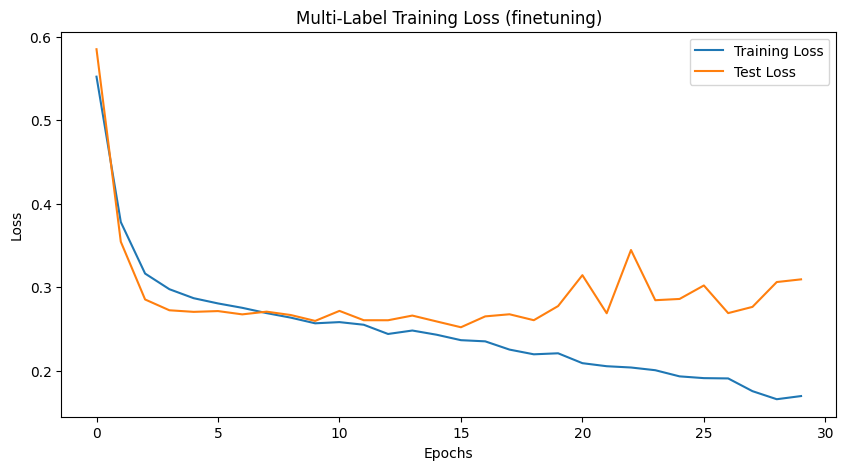

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Multi-Label Training Loss (finetuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [65]:
print("Retina Pretrained")
print("TRAIN")
final_eval(classifier_model,train_loader)
print("TEST")
x = final_eval(classifier_model,test_loader)

Retina Pretrained
TRAIN
  Sequence Accuracy: 0.4322
  Micro F1:          0.5640
  Macro F1:          0.2982
  Macro AUC:         0.9323
TEST
  Sequence Accuracy: 0.2258
  Micro F1:          0.3000
  Macro F1:          0.1402
  Macro AUC:         0.7324


## Retrained Retina Lite Classifier from scratch

In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier_model = RetinaLiteClassifier()
classifier_model = classifier_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.001)

num_epochs = 30
train_losses_retrain = []
test_losses_retrain = []

print(f"Starting Multi-Label Training on {device}...")

for epoch in range(num_epochs):
    classifier_model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = classifier_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses_retrain.append(epoch_train_loss)

    classifier_model.eval()
    running_test_loss = 0.0
    total_elements = 0
    correct_elements = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]", leave=False):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = classifier_model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            correct_elements += (preds == labels).sum().item()
            total_elements += labels.numel()

    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_acc = 100 * correct_elements / total_elements

    test_losses_retrain.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Element Acc: {epoch_acc:.2f}%")

Starting Multi-Label Training on cuda...


Epoch [1/30] | Train Loss: 0.6132 | Test Loss: 0.6340 | Element Acc: 78.57%


Epoch [2/30] | Train Loss: 0.4015 | Test Loss: 0.3778 | Element Acc: 91.63%


Epoch [3/30] | Train Loss: 0.3225 | Test Loss: 0.2858 | Element Acc: 91.63%


Epoch [4/30] | Train Loss: 0.2997 | Test Loss: 0.2821 | Element Acc: 91.63%


Epoch [5/30] | Train Loss: 0.2834 | Test Loss: 0.2761 | Element Acc: 91.63%


Epoch [6/30] | Train Loss: 0.2818 | Test Loss: 0.2751 | Element Acc: 91.63%


Epoch [7/30] | Train Loss: 0.2748 | Test Loss: 0.2730 | Element Acc: 91.63%


Epoch [8/30] | Train Loss: 0.2747 | Test Loss: 0.2729 | Element Acc: 91.63%


Epoch [9/30] | Train Loss: 0.2677 | Test Loss: 0.2739 | Element Acc: 91.63%


Epoch [10/30] | Train Loss: 0.2695 | Test Loss: 0.2709 | Element Acc: 91.63%


Epoch [11/30] | Train Loss: 0.2621 | Test Loss: 0.2707 | Element Acc: 91.63%


Epoch [12/30] | Train Loss: 0.2600 | Test Loss: 0.2693 | Element Acc: 91.63%


Epoch [13/30] | Train Loss: 0.2597 | Test Loss: 0.2664 | Element Acc: 91.63%


Epoch [14/30] | Train Loss: 0.2516 | Test Loss: 0.2655 | Element Acc: 91.63%


Epoch [15/30] | Train Loss: 0.2584 | Test Loss: 0.2722 | Element Acc: 91.63%


Epoch [16/30] | Train Loss: 0.2530 | Test Loss: 0.2789 | Element Acc: 91.71%


Epoch [17/30] | Train Loss: 0.2450 | Test Loss: 0.2729 | Element Acc: 91.71%


Epoch [18/30] | Train Loss: 0.2501 | Test Loss: 0.2694 | Element Acc: 91.63%


Epoch [19/30] | Train Loss: 0.2404 | Test Loss: 0.2590 | Element Acc: 91.71%


Epoch [20/30] | Train Loss: 0.2367 | Test Loss: 0.2678 | Element Acc: 91.63%


Epoch [21/30] | Train Loss: 0.2293 | Test Loss: 0.2651 | Element Acc: 91.40%


Epoch [22/30] | Train Loss: 0.2287 | Test Loss: 0.2782 | Element Acc: 91.78%


Epoch [23/30] | Train Loss: 0.2193 | Test Loss: 0.2626 | Element Acc: 91.32%


Epoch [24/30] | Train Loss: 0.2204 | Test Loss: 0.2922 | Element Acc: 90.94%


Epoch [25/30] | Train Loss: 0.2177 | Test Loss: 0.2686 | Element Acc: 91.71%


Epoch [26/30] | Train Loss: 0.2094 | Test Loss: 0.2679 | Element Acc: 91.63%


Epoch [27/30] | Train Loss: 0.2048 | Test Loss: 0.2697 | Element Acc: 91.71%


Epoch [28/30] | Train Loss: 0.1959 | Test Loss: 0.2828 | Element Acc: 91.24%


Epoch [29/30] | Train Loss: 0.1967 | Test Loss: 0.2954 | Element Acc: 91.32%


Epoch [30/30] | Train Loss: 0.1936 | Test Loss: 0.2939 | Element Acc: 91.01%


In [67]:
save_directory = "/content/drive/MyDrive/DL Final Project/"
filename = "retrained_Retina_classifer.pth"
save_path = os.path.join(save_directory, filename)

torch.save(classifier_model.state_dict(), save_path)
print(f"\nSaved to: {save_path}")


Saved to: /content/drive/MyDrive/DL Final Project/retrained_Retina_classifer.pth


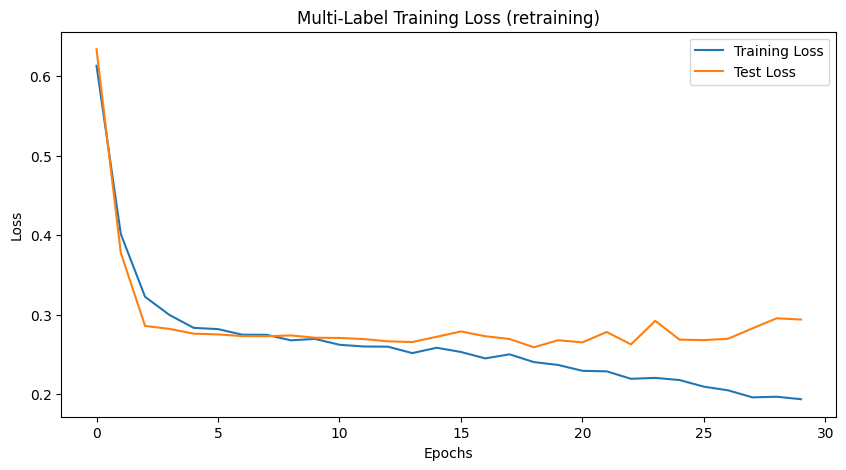

In [68]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_retrain, label='Training Loss')
plt.plot(test_losses_retrain, label='Test Loss')
plt.title('Multi-Label Training Loss (retraining)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
print("Retina Retrained")
print("TRAIN")
final_eval(classifier_model,train_loader)
print("TEST")
x = final_eval(classifier_model,test_loader)


Retina Retrained
TRAIN
  Sequence Accuracy: 0.2196
  Micro F1:          0.3355
  Macro F1:          0.1632
  Macro AUC:         0.9180
TEST
  Sequence Accuracy: 0.0753
  Micro F1:          0.1069
  Macro F1:          0.0313
  Macro AUC:         0.6796


### Training a Resnet 18 model

In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 14)

resnet_model = resnet_model.to(device)

print("ResNet18 initialized for 14-class Multi-Label classification.")

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)

num_epochs = 30
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    resnet_model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    resnet_model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1} [Test]", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = resnet_model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()

    epoch_test_loss = running_test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}")

ResNet18 initialized for 14-class Multi-Label classification.


Epoch [1/30] | Train Loss: 0.6320 | Test Loss: 0.5108


Epoch [2/30] | Train Loss: 0.3538 | Test Loss: 0.3295


Epoch [3/30] | Train Loss: 0.2223 | Test Loss: 0.2651


Epoch [4/30] | Train Loss: 0.1505 | Test Loss: 0.2353


Epoch [5/30] | Train Loss: 0.1124 | Test Loss: 0.2212


Epoch [6/30] | Train Loss: 0.0824 | Test Loss: 0.2126


Epoch [7/30] | Train Loss: 0.0639 | Test Loss: 0.2028


Epoch [8/30] | Train Loss: 0.0505 | Test Loss: 0.2027


Epoch [9/30] | Train Loss: 0.0418 | Test Loss: 0.1978


Epoch [10/30] | Train Loss: 0.0350 | Test Loss: 0.1958


Epoch [11/30] | Train Loss: 0.0307 | Test Loss: 0.1969


Epoch [12/30] | Train Loss: 0.0267 | Test Loss: 0.1962


Epoch [13/30] | Train Loss: 0.0235 | Test Loss: 0.1952


Epoch [14/30] | Train Loss: 0.0215 | Test Loss: 0.1956


Epoch [15/30] | Train Loss: 0.0196 | Test Loss: 0.1997


Epoch [16/30] | Train Loss: 0.0180 | Test Loss: 0.1963


Epoch [17/30] | Train Loss: 0.0160 | Test Loss: 0.1959


Epoch [18/30] | Train Loss: 0.0145 | Test Loss: 0.1926


Epoch [19/30] | Train Loss: 0.0135 | Test Loss: 0.1982


Epoch [20/30] | Train Loss: 0.0128 | Test Loss: 0.1984


Epoch [21/30] | Train Loss: 0.0117 | Test Loss: 0.1983


Epoch [22/30] | Train Loss: 0.0108 | Test Loss: 0.2003


Epoch [23/30] | Train Loss: 0.0102 | Test Loss: 0.2008


Epoch [24/30] | Train Loss: 0.0099 | Test Loss: 0.2016


Epoch [25/30] | Train Loss: 0.0092 | Test Loss: 0.2011


Epoch [26/30] | Train Loss: 0.0092 | Test Loss: 0.2024


Epoch [27/30] | Train Loss: 0.0086 | Test Loss: 0.2119


Epoch [28/30] | Train Loss: 0.0082 | Test Loss: 0.2023


Epoch [29/30] | Train Loss: 0.0079 | Test Loss: 0.1987


Epoch [30/30] | Train Loss: 0.0078 | Test Loss: 0.2004


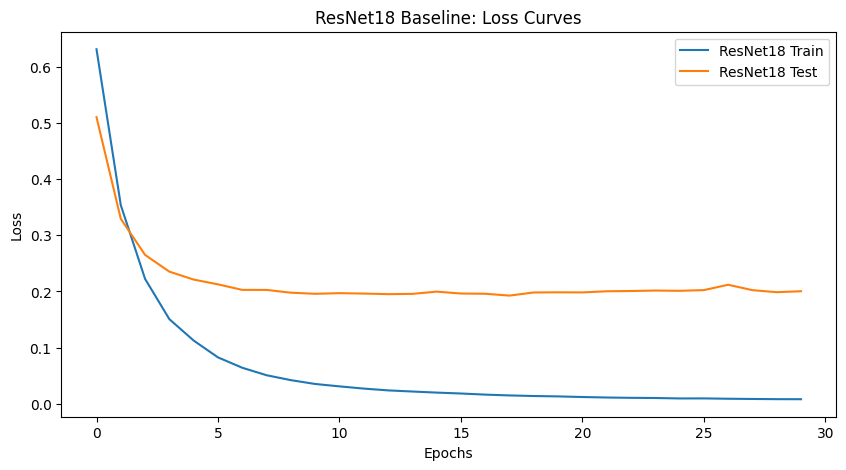

In [75]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='ResNet18 Train')
plt.plot(test_losses, label='ResNet18 Test')
plt.title('ResNet18 Baseline: Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [76]:
save_path = "/content/drive/MyDrive/DL Final Project/resnet18_baseline.pth"
torch.save(resnet_model.state_dict(), save_path)
print(f"Saved baseline to {save_path}")

Saved baseline to /content/drive/MyDrive/DL Final Project/resnet18_baseline.pth


In [77]:
print("Resnet18 pretrained")
print("TRAIN")
final_eval(resnet_model,train_loader)
print("TEST")
x = final_eval(resnet_model,test_loader)

Resnet18 pretrained
TRAIN
  Sequence Accuracy: 1.0000
  Micro F1:          1.0000
  Macro F1:          1.0000
  Macro AUC:         1.0000
TEST
  Sequence Accuracy: 0.3226
  Micro F1:          0.4908
  Macro F1:          0.4183
  Macro AUC:         0.8836


## Simple Convnet

####Architecture

In [ ]:
class SimpleConvNet(nn.Module):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2)
        # self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 14)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        # x = self.pool(self.relu(self.conv1(x)))
        # x = self.pool(self.relu(self.conv2(x)))
        # x = self.pool(self.relu(self.conv3(x)))
        x = (self.relu(self.conv1(x)))
        x = (self.relu(self.conv2(x)))
        x = (self.relu(self.conv3(x)))
        # x = x.view(-1, 128 * 4 * 4)
        x = x.view(-1, 128 * 32 * 32)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
model = SimpleConvNet()
print(sum(p.numel() for p in model.parameters()))

67504974


####Training

In [ ]:
classifier_model = SimpleConvNet()
classifier_model = classifier_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.001, weight_decay=5e-3)

num_epochs = 15
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    classifier_model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = classifier_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    classifier_model.eval()
    running_test_loss = 0.0
    total_elements = 0
    correct_elements = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]", leave=False):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = classifier_model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            correct_elements += (preds == labels).sum().item()
            total_elements += labels.numel()

    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_acc = 100 * correct_elements / total_elements

    test_losses.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Element Acc: {epoch_acc:.2f}%")

Epoch [1/15] | Train Loss: 0.3378 | Test Loss: 0.2738 | Element Acc: 91.63%


Epoch [2/15] | Train Loss: 0.2729 | Test Loss: 0.2805 | Element Acc: 91.63%


Epoch [3/15] | Train Loss: 0.2718 | Test Loss: 0.2774 | Element Acc: 91.63%


Epoch [4/15] | Train Loss: 0.2719 | Test Loss: 0.2767 | Element Acc: 91.63%


Epoch [5/15] | Train Loss: 0.2654 | Test Loss: 0.2730 | Element Acc: 91.63%


Epoch [6/15] | Train Loss: 0.2681 | Test Loss: 0.2747 | Element Acc: 91.63%


Epoch [7/15] | Train Loss: 0.2627 | Test Loss: 0.2723 | Element Acc: 91.63%


Epoch [8/15] | Train Loss: 0.2627 | Test Loss: 0.2765 | Element Acc: 91.63%


Epoch [9/15] | Train Loss: 0.2672 | Test Loss: 0.2759 | Element Acc: 91.78%


Epoch [10/15] | Train Loss: 0.2596 | Test Loss: 0.2664 | Element Acc: 91.63%


Epoch [11/15] | Train Loss: 0.2538 | Test Loss: 0.2670 | Element Acc: 91.63%


Epoch [12/15] | Train Loss: 0.2567 | Test Loss: 0.2667 | Element Acc: 91.63%


Epoch [13/15] | Train Loss: 0.2548 | Test Loss: 0.2741 | Element Acc: 91.63%


Epoch [14/15] | Train Loss: 0.2591 | Test Loss: 0.2656 | Element Acc: 91.63%


Epoch [15/15] | Train Loss: 0.2591 | Test Loss: 0.2643 | Element Acc: 91.63%


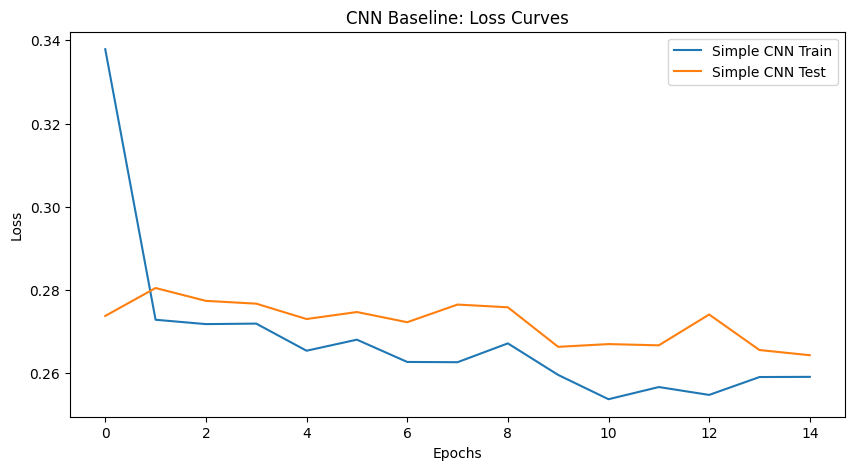

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Simple CNN Train')
plt.plot(test_losses, label='Simple CNN Test')
plt.title('CNN Baseline: Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
print("Simple Covnet")
print("TRAIN")
final_eval(classifier_model,train_loader)
print("TEST")
x = final_eval(classifier_model,test_loader)

Simple Covnet
TRAIN
  Sequence Accuracy: 0.0000
  Micro F1:          0.0000
  Macro F1:          0.0000
  Macro AUC:         0.7497
TEST
  Sequence Accuracy: 0.0000
  Micro F1:          0.0000
  Macro F1:          0.0000
  Macro AUC:         0.6880


## Training a Vision Transformer

In [34]:
import torch
import torch.nn as nn
from timm import create_model

NUM_CLASSES = 14

class ViTClassifier(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()
        self.backbone = create_model(
            "vit_base_patch16_224",
            pretrained=True,
            num_classes=num_classes,
        )

    def forward(self, x):
        return self.backbone(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViTClassifier(num_classes=NUM_CLASSES).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,} | Trainable: {trainable_params:,}")
print(f"Using device: {device}")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Total params: 85,809,422 | Trainable: 85,809,422
Using device: cuda


In [35]:
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset_vit = AugmentedImageDataset(
    annotations_file=train_csv,
    img_dir=train_img_dir,
    augment_fn=augment_image,
    transform=vit_transform
)

train_loader = DataLoader(train_dataset_vit, batch_size=32, shuffle=True)

test_dataset_vit = AugmentedImageDataset(
    annotations_file=test_csv,
    img_dir=test_img_dir,
    augment_fn=None,
    transform=vit_transform
)

test_loader = DataLoader(test_dataset_vit, batch_size=32, shuffle=False)

print(f"Train dataset size: {len(train_dataset_vit)}")
print(f"Test dataset size: {len(test_dataset_vit)}")


Processing dataset from /content/drive/MyDrive/DL Final Project/STARE_cleaned/train_labels.csv...
Processing dataset from /content/drive/MyDrive/DL Final Project/STARE_cleaned/test_labels.csv...
Train dataset size: 428
Test dataset size: 93


In [36]:
classifier_model = ViTClassifier(14)
classifier_model = classifier_model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.001, weight_decay=1e-3)

num_epochs = 30
train_losses = []
test_losses = []

print(f"Starting Multi-Label Training on {device}...")

for epoch in range(num_epochs):
    classifier_model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = classifier_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    classifier_model.eval()
    running_test_loss = 0.0
    total_elements = 0
    correct_elements = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]", leave=False):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = classifier_model(images)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            correct_elements += (preds == labels).sum().item()
            total_elements += labels.numel()

    epoch_test_loss = running_test_loss / len(test_loader)
    epoch_acc = 100 * correct_elements / total_elements

    test_losses.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f} | Element Acc: {epoch_acc:.2f}%")

Starting Multi-Label Training on cuda...


Epoch [1/30] | Train Loss: 0.5242 | Test Loss: 0.2756 | Element Acc: 91.63%


Epoch [2/30] | Train Loss: 0.2907 | Test Loss: 0.2986 | Element Acc: 91.63%


Epoch [3/30] | Train Loss: 0.2771 | Test Loss: 0.2792 | Element Acc: 91.55%


Epoch [4/30] | Train Loss: 0.2675 | Test Loss: 0.2912 | Element Acc: 91.63%


Epoch [5/30] | Train Loss: 0.2735 | Test Loss: 0.2836 | Element Acc: 91.40%


Epoch [6/30] | Train Loss: 0.2619 | Test Loss: 0.2820 | Element Acc: 91.24%


Epoch [7/30] | Train Loss: 0.2608 | Test Loss: 0.2705 | Element Acc: 91.63%


Epoch [8/30] | Train Loss: 0.2615 | Test Loss: 0.2716 | Element Acc: 91.55%


Epoch [9/30] | Train Loss: 0.2602 | Test Loss: 0.2772 | Element Acc: 91.40%


Epoch [10/30] | Train Loss: 0.2597 | Test Loss: 0.2974 | Element Acc: 91.09%


Epoch [11/30] | Train Loss: 0.2873 | Test Loss: 0.2748 | Element Acc: 91.63%


Epoch [12/30] | Train Loss: 0.2603 | Test Loss: 0.2669 | Element Acc: 91.63%


Epoch [13/30] | Train Loss: 0.2575 | Test Loss: 0.2699 | Element Acc: 91.55%


Epoch [14/30] | Train Loss: 0.2519 | Test Loss: 0.2708 | Element Acc: 91.47%


Epoch [15/30] | Train Loss: 0.2524 | Test Loss: 0.2634 | Element Acc: 91.63%


Epoch [16/30] | Train Loss: 0.2545 | Test Loss: 0.2766 | Element Acc: 91.55%


Epoch [17/30] | Train Loss: 0.2527 | Test Loss: 0.2734 | Element Acc: 91.47%


Epoch [18/30] | Train Loss: 0.2492 | Test Loss: 0.2957 | Element Acc: 89.48%


Epoch [19/30] | Train Loss: 0.2529 | Test Loss: 0.2742 | Element Acc: 91.63%


Epoch [20/30] | Train Loss: 0.2524 | Test Loss: 0.2838 | Element Acc: 89.55%


Epoch [21/30] | Train Loss: 0.2530 | Test Loss: 0.2869 | Element Acc: 91.55%


Epoch [22/30] | Train Loss: 0.2513 | Test Loss: 0.2738 | Element Acc: 91.63%


Epoch [23/30] | Train Loss: 0.2508 | Test Loss: 0.2888 | Element Acc: 91.71%


Epoch [24/30] | Train Loss: 0.2460 | Test Loss: 0.2680 | Element Acc: 91.78%


Epoch [25/30] | Train Loss: 0.2475 | Test Loss: 0.2740 | Element Acc: 91.47%


Epoch [26/30] | Train Loss: 0.2470 | Test Loss: 0.2842 | Element Acc: 90.78%


Epoch [27/30] | Train Loss: 0.2483 | Test Loss: 0.2719 | Element Acc: 91.55%


Epoch [28/30] | Train Loss: 0.2436 | Test Loss: 0.2759 | Element Acc: 91.55%


Epoch [29/30] | Train Loss: 0.2471 | Test Loss: 0.2781 | Element Acc: 91.55%


Epoch [30/30] | Train Loss: 0.2378 | Test Loss: 0.2704 | Element Acc: 91.47%


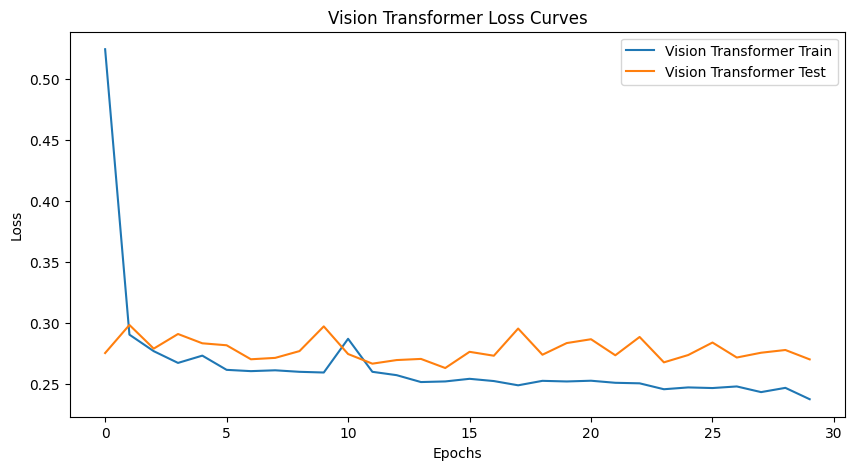

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Vision Transformer Train')
plt.plot(test_losses, label='Vision Transformer Test')
plt.title('Vision Transformer Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
print("Vision Transformer")
print("TRAIN")
final_eval(classifier_model,train_loader)
print("TEST")
x = final_eval(classifier_model,test_loader)

Vision Transformer
TRAIN
  Sequence Accuracy: 0.0491
  Micro F1:          0.0866
  Macro F1:          0.0751
  Macro AUC:         0.7913
TEST
  Sequence Accuracy: 0.0215
  Micro F1:          0.0348
  Macro F1:          0.0357
  Macro AUC:         0.7188


## Changing up a problem. Healthy eyes or Disease

In [39]:
import torch
import torch.nn as nn
from tqdm import tqdm

pos_count = 0
total_count = 0

for _, labels in train_loader:
    pos_count += labels[:, 0].sum()
    total_count += labels.shape[0]

neg_count = total_count - pos_count
class0_weight = (neg_count / (pos_count + 1e-5))
class0_weight = torch.tensor([class0_weight]).float().to(device)

print(f"Using Weight: {class0_weight.item():.2f}")

Using Weight: 6.13


In [40]:
classifier_model = RetinaLiteClassifier()
classifier_model = classifier_model.to(device)

In [41]:
train_dataset = AugmentedImageDataset(
    annotations_file=train_csv,
    img_dir=train_img_dir,
    augment_fn=augment_image,
    transform=resize_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = AugmentedImageDataset(
    annotations_file=test_csv,
    img_dir=test_img_dir,
    augment_fn=None,
    transform=resize_transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Processing dataset from /content/drive/MyDrive/DL Final Project/STARE_cleaned/train_labels.csv...
Processing dataset from /content/drive/MyDrive/DL Final Project/STARE_cleaned/test_labels.csv...


In [42]:
criterion = nn.BCEWithLogitsLoss(pos_weight=class0_weight)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, classifier_model.parameters()), lr=0.001)

num_epochs = 30
train_losses_binary = []
test_losses_binary = []

for epoch in range(num_epochs):
    classifier_model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        outputs = classifier_model(images)

        binary_output = outputs[:, 0:1]
        binary_label = labels[:, 0:1]

        loss = criterion(binary_output, binary_label)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(classifier_model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses_binary.append(epoch_train_loss)

    classifier_model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]", leave=False):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = classifier_model(images)

            binary_output = outputs[:, 0:1]
            binary_label = labels[:, 0:1]

            loss = criterion(binary_output, binary_label)

            running_test_loss += loss.item()

    epoch_test_loss = running_test_loss / len(test_loader)
    test_losses_binary.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}")

Epoch [1/30] | Train Loss: 1.1904 | Test Loss: 1.0318


Epoch [2/30] | Train Loss: 1.1484 | Test Loss: 0.9998


Epoch [3/30] | Train Loss: 1.0876 | Test Loss: 0.9463


Epoch [4/30] | Train Loss: 1.0417 | Test Loss: 0.8266


Epoch [5/30] | Train Loss: 1.0732 | Test Loss: 1.1172


Epoch [6/30] | Train Loss: 0.9432 | Test Loss: 0.8887


Epoch [7/30] | Train Loss: 0.9340 | Test Loss: 1.1382


Epoch [8/30] | Train Loss: 0.7932 | Test Loss: 1.0356


Epoch [9/30] | Train Loss: 0.7678 | Test Loss: 1.3797


Epoch [10/30] | Train Loss: 0.7193 | Test Loss: 1.4241


Epoch [11/30] | Train Loss: 0.6552 | Test Loss: 1.2546


Epoch [12/30] | Train Loss: 0.6613 | Test Loss: 1.1786


Epoch [13/30] | Train Loss: 0.5489 | Test Loss: 1.4045


Epoch [14/30] | Train Loss: 0.5656 | Test Loss: 1.3798


Epoch [15/30] | Train Loss: 0.4424 | Test Loss: 1.4989


Epoch [16/30] | Train Loss: 0.5032 | Test Loss: 1.9734


Epoch [17/30] | Train Loss: 0.5177 | Test Loss: 1.8368


Epoch [18/30] | Train Loss: 0.5466 | Test Loss: 1.5890


Epoch [19/30] | Train Loss: 0.3358 | Test Loss: 1.7685


Epoch [20/30] | Train Loss: 0.2596 | Test Loss: 1.9379


Epoch [21/30] | Train Loss: 0.2350 | Test Loss: 1.7856


Epoch [22/30] | Train Loss: 0.4770 | Test Loss: 2.2161


Epoch [23/30] | Train Loss: 0.2067 | Test Loss: 2.4966


Epoch [24/30] | Train Loss: 0.2178 | Test Loss: 1.9447


Epoch [25/30] | Train Loss: 0.1445 | Test Loss: 1.8776


Epoch [26/30] | Train Loss: 0.3200 | Test Loss: 2.3195


Epoch [27/30] | Train Loss: 0.2738 | Test Loss: 2.4725


Epoch [28/30] | Train Loss: 0.1890 | Test Loss: 2.0033


Epoch [29/30] | Train Loss: 0.0866 | Test Loss: 2.7268


Epoch [30/30] | Train Loss: 0.1332 | Test Loss: 2.3418


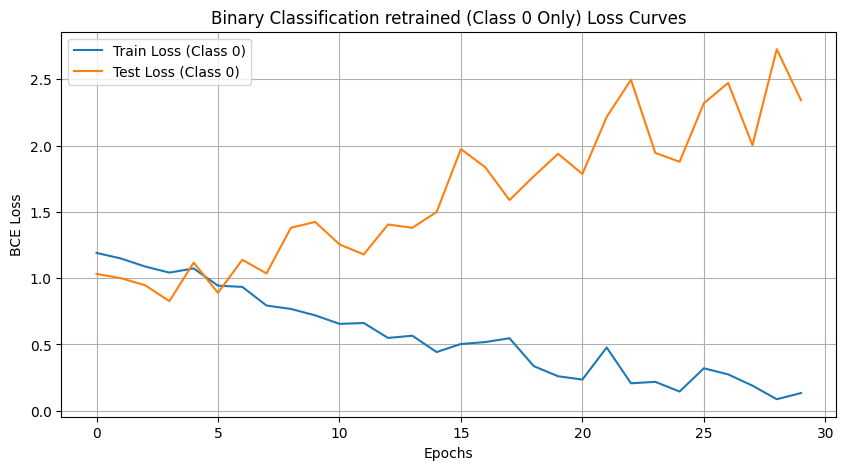

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_binary, label='Train Loss (Class 0)')
plt.plot(test_losses_binary, label='Test Loss (Class 0)')
plt.title('Binary Classification retrained (Class 0 Only) Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [44]:
save_path = "/content/drive/MyDrive/DL Final Project/retina_lite_classifier_binary.pth"
torch.save(classifier_model.state_dict(), save_path)

print(f"Binary classification model saved successfully to: {save_path}")

Binary classification model saved successfully to: /content/drive/MyDrive/DL Final Project/retina_lite_classifier_binary.pth


In [45]:
print("Binary Healhty or Not |  Retinal Lite")
print("TRAIN")
final_eval(classifier_model,train_loader)
print("TEST")
x = final_eval(classifier_model,test_loader)

Binary Healhty or Not |  Retinal Lite
TRAIN
  Sequence Accuracy: 0.0000
  Micro F1:          0.1604
  Macro F1:          0.1560
  Macro AUC:         0.5301
TEST
  Sequence Accuracy: 0.0000
  Micro F1:          0.1575
  Macro F1:          0.1532
  Macro AUC:         0.5430


## Healthy Or Not Pretrained

In [46]:
classifier_model = RetinaLiteClassifier()
classifier_model = classifier_model.to(device)

model_path = "/content/drive/MyDrive/DL Final Project/model_final.pth"

if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=device)
    classifier_model.load_state_dict(state_dict, strict=False)
    print("Pre-trained weights loaded.")

    for param in classifier_model.encoder.parameters():
        param.requires_grad = False
    for param in classifier_model.bottleneck.parameters():
        param.requires_grad = False
    print("Backbone layers frozen.")
else:
    print(f"Model file not found at {model_path}")

Pre-trained weights loaded.
Backbone layers frozen.


In [47]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_model.parameters()), lr=0.001)
criterion = nn.BCEWithLogitsLoss(pos_weight=class0_weight)

num_epochs = 30
train_losses_binary_pretrained = []
test_losses_binary_pretrained = []

print(f"Starting Binary Fine-Tuning on {device}...")

for epoch in range(num_epochs):
    classifier_model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False):
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = classifier_model(images)

        binary_output = outputs[:, 0:1]
        binary_label = labels[:, 0:1]

        loss = criterion(binary_output, binary_label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_train_loss = running_loss / len(train_loader)
    train_losses_binary_pretrained.append(epoch_train_loss)

    classifier_model.eval()
    running_test_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]", leave=False):
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = classifier_model(images)

            binary_output = outputs[:, 0:1]
            binary_label = labels[:, 0:1]

            loss = criterion(binary_output, binary_label)
            running_test_loss += loss.item()

    epoch_test_loss = running_test_loss / len(test_loader)
    test_losses_binary_pretrained.append(epoch_test_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}")

Starting Binary Fine-Tuning on cuda...


Epoch [1/30] | Train Loss: 1.1642 | Test Loss: 1.0087


Epoch [2/30] | Train Loss: 1.0370 | Test Loss: 0.9203


Epoch [3/30] | Train Loss: 0.9195 | Test Loss: 0.8781


Epoch [4/30] | Train Loss: 0.8723 | Test Loss: 0.7686


Epoch [5/30] | Train Loss: 0.6969 | Test Loss: 0.8458


Epoch [6/30] | Train Loss: 0.5626 | Test Loss: 0.9117


Epoch [7/30] | Train Loss: 0.4755 | Test Loss: 0.7746


Epoch [8/30] | Train Loss: 0.3426 | Test Loss: 1.0839


Epoch [9/30] | Train Loss: 0.2246 | Test Loss: 1.0233


Epoch [10/30] | Train Loss: 0.1850 | Test Loss: 1.6086


Epoch [11/30] | Train Loss: 0.1328 | Test Loss: 1.1178


Epoch [12/30] | Train Loss: 0.0966 | Test Loss: 1.4362


Epoch [13/30] | Train Loss: 0.1060 | Test Loss: 1.5377


Epoch [14/30] | Train Loss: 0.0535 | Test Loss: 1.6058


Epoch [15/30] | Train Loss: 0.0286 | Test Loss: 2.0434


Epoch [16/30] | Train Loss: 0.0218 | Test Loss: 1.9194


Epoch [17/30] | Train Loss: 0.0156 | Test Loss: 1.7457


Epoch [18/30] | Train Loss: 0.0121 | Test Loss: 1.7479


Epoch [19/30] | Train Loss: 0.0112 | Test Loss: 2.0806


Epoch [20/30] | Train Loss: 0.0167 | Test Loss: 1.8649


Epoch [21/30] | Train Loss: 0.0090 | Test Loss: 1.9005


Epoch [22/30] | Train Loss: 0.0125 | Test Loss: 2.0074


Epoch [23/30] | Train Loss: 0.0100 | Test Loss: 2.5160


Epoch [24/30] | Train Loss: 0.0086 | Test Loss: 2.5370


Epoch [25/30] | Train Loss: 0.0076 | Test Loss: 2.3175


Epoch [26/30] | Train Loss: 0.0043 | Test Loss: 2.4641


Epoch [27/30] | Train Loss: 0.0050 | Test Loss: 2.4008


Epoch [28/30] | Train Loss: 0.0156 | Test Loss: 2.3553


Epoch [29/30] | Train Loss: 0.0309 | Test Loss: 3.7790


Epoch [30/30] | Train Loss: 0.0462 | Test Loss: 1.5774


In [48]:
save_path = "/content/drive/MyDrive/DL Final Project/retina_lite_binary_finetuned.pth"
torch.save(classifier_model.state_dict(), save_path)
print(f"Saved binary fine-tuned model to: {save_path}")

Saved binary fine-tuned model to: /content/drive/MyDrive/DL Final Project/retina_lite_binary_finetuned.pth


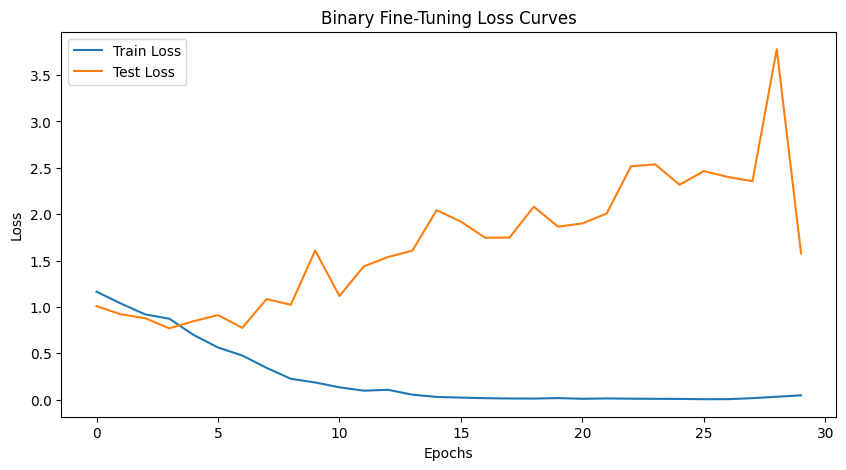

In [49]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses_binary_pretrained, label='Train Loss')
plt.plot(test_losses_binary_pretrained, label='Test Loss')
plt.title('Binary Fine-Tuning Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
print("Binary Healhty or Not | Retrained RetinalLite")
print("TRAIN")
final_eval(classifier_model,train_loader)
print("TEST")
x = final_eval(classifier_model,test_loader)

Binary Healhty or Not | Retrained RetinalLite
TRAIN
  Sequence Accuracy: 0.0000
  Micro F1:          0.1295
  Macro F1:          0.1196
  Macro AUC:         0.5264
TEST
  Sequence Accuracy: 0.0000
  Micro F1:          0.1402
  Macro F1:          0.1105
  Macro AUC:         0.5032
